In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import datetime as dt

pd.options.mode.chained_assignment = None  # default='warn'

/Users/fqian/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn import svm

## 1. Data Cleaning and Feature Engineering

#### 1.1 First clean: only take the useful columns

In [4]:
round3 = pd.read_json("round3_merged.json")
round2 = pd.read_json("round2_merged.json")
round1 = pd.read_json("round1_merged.json")

In [5]:
round3_clean = round3[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round2_clean = round2[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round1_clean = round1[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "availability", "price", "discount",
                       "calendars", "price_requested"]]

print "Number of observations in round 3: ", len(round3_clean)
print "Number of observations in round 2: ", len(round2_clean)
print "Number of observations in round 1: ", len(round1_clean)

# round3_clean.reset_index(drop=True).head()

Number of observations in round 3:  288
Number of observations in round 2:  226
Number of observations in round 1:  194


In [6]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})
# round1_clean.head()

In [7]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})
round1_clean["percent_agreed"] = [np.nan if val==None else float(val.strip("%"))/100. for val in  round1_clean.percent_agreed.values]

combined = pd.concat([round1_clean, round2_clean, round3_clean], keys=["round1", "round2", "round3"], ignore_index=False)
combined["source"] = combined.index.labels[0]+1
combined = combined.reset_index(drop=True)

In [8]:
# combined.head()

In [9]:
combined.isnull().sum()

bucket_name                    0
calendars                      0
decision                       0
discount_agreed              705
discount_asked                 0
host_acceptance_rate          56
host_id                        0
host_response_rate            20
host_total_listings_count      0
id                             0
instant_bookable               0
nightly_price                  0
percent_agreed               703
price_agreed                 573
price_requested              283
room_type                      0
source                         0
dtype: int64

#### 1.2 Add useful independent variables

Add variables from the calendars:
* median price
* standard deviation （normalized, using the median price)

In [10]:
calendar_price =  np.array([(np.median(calendar["price_USD"].values()), np.std(calendar["price_USD"].values()), np.max(calendar["price_USD"].values())) 
                            for calendar in combined["calendars"].values])
calendar_median_price = calendar_price[:,0]
calendar_price_std = calendar_price[:,1]
calendar_price_high = calendar_price[:,2]

combined["price_median"]=calendar_median_price
combined["price_std"]=calendar_price_std/calendar_median_price
combined["orig_percent_off"]=1-combined["nightly_price"]/calendar_price_high

* 1-month occupancy rate

In [11]:
key_1m = map(str, range(30))
calendar_occupancy = [np.mean([calendar["availability"][key] for key in key_1m]) for calendar in combined["calendars"].values]

combined["occupancy_1m"]=calendar_occupancy

Convert string variables to numeric:
* whether room will be shared
* whether instant booking is turned on
* the response rate of the host (contains nans)

In [12]:
shared = combined["room_type"].values
combined["shared"] = [x!="Entire home/apt" for x in shared]
# shared_binary

instant = combined["instant_bookable"].values
combined["instant"] = [x=="t" for x in shared]
# instant_binary

In [13]:
response_imputer = Imputer(copy=True, missing_values='NaN', strategy='mean', axis=1)
response_num = np.array([float(response_rate.strip('%'))/100 for response_rate in combined["host_response_rate"].fillna(value="-100%").values])
response_num = np.array([np.nan if x < 0 else x for x in response_num])
# response_imputer.fit(response_num)
response_imputed = response_imputer.fit_transform(response_num)[0]

# print len(response_imputed)
combined["response_rate"] = response_imputed

/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


#### 1.3 Add indicators for the buckets

Construct 11 variables: 3 types of orphans, 2 types of advances, and 3x2=6 types of interactions

In [14]:
opening_attr = combined["bucket_name"].values
# orphan = []
# advance = []
N = len(opening_attr)
orp_1 = np.zeros(N)
orp_2 = np.zeros(N)
orp_3 = np.zeros(N)
adv_1 = np.zeros(N)
adv_2 = np.zeros(N)

for (i,x) in enumerate(opening_attr):
    if x == "days1_weeks1":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days1_weeks2":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days1_weeksM":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days2_weeks1":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days2_weeks2":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days2_weeksM":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days3_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days3_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days3_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "daysM_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "daysM_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "daysM_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
        
combined["orp_1"]=orp_1
combined["orp_2"]=orp_2
combined["orp_3"]=orp_3
combined["adv_1"]=adv_1
combined["adv_2"]=adv_2

In [15]:
combined["orp_1, adv_1"] = combined["orp_1"]*combined["adv_1"]
combined["orp_1, adv_2"] = combined["orp_1"]*combined["adv_2"]
combined["orp_2, adv_1"] = combined["orp_2"]*combined["adv_1"]
combined["orp_2, adv_2"] = combined["orp_2"]*combined["adv_2"]
combined["orp_3, adv_1"] = combined["orp_3"]*combined["adv_1"]
combined["orp_3, adv_2"] = combined["orp_3"]*combined["adv_2"]

In [16]:
# combined.columns

#### 1.4 Process the decision variables:

Calculate the percentage of the discount agreed:

In [17]:
combined.groupby("decision")["id"].count()/len(combined)

decision
-1    0.471751
 0    0.316384
 1    0.211864
Name: id, dtype: float64

In [18]:
orig_price = combined["nightly_price"]
price_agreed_percent = (np.nan_to_num(combined["price_agreed"])/orig_price)
discount_agreed1 = [0 if (d>=1 or d==0) else 1-d for d in price_agreed_percent]
discount_agreed2 = np.nan_to_num(combined["discount_agreed"]/orig_price)
discount_agreed3 = np.nan_to_num(combined["percent_agreed"])

discount_obtained = np.max([discount_agreed1, discount_agreed2, discount_agreed3], axis=0)
# print discount_agreed

combined["discount_obtained"] = discount_obtained

#### 1.5 Again, only keep the useful columns

In [19]:
# combined.columns

In [20]:
combined_clean = combined[["host_total_listings_count", "response_rate", "instant", "shared", 
                               "price_median", "price_std", "occupancy_1m",
                               "orp_1", "orp_2", "orp_3", "adv_1", "adv_2", 
                               "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
                               "orig_percent_off", "discount_asked", "decision", "discount_obtained", "source"]]

In [21]:
combined_clean.head()

,host_total_listings_count,response_rate,instant,shared,price_median,price_std,occupancy_1m,orp_1,orp_2,orp_3,...,"orp_1, adv_2","orp_2, adv_1","orp_2, adv_2","orp_3, adv_1","orp_3, adv_2",orig_percent_off,discount_asked,decision,discount_obtained,source
0,1,1,False,True,45,0.090351,0.433333,0,0,0,...,0,0,0,0,0,0.055556,0.7,0,0,1
1,1,1,False,False,106,0.144629,0.700000,1,0,0,...,0,0,0,0,0,0.000000,0.7,-1,0,1
2,5,1,False,True,46,0.021650,0.366667,0,0,1,...,0,0,0,1,0,0.108696,0.9,-1,0,1
3,2,1,False,False,120,0.095207,0.500000,0,1,0,...,0,1,0,0,0,0.246269,0.7,-1,0,1
4,1,1,False,True,65,0.000000,0.933333,0,0,0,...,0,0,0,0,0,0.000000,0.6,0,0,1


## 2. Construct training samples

For studying whether hosts are negotiable, we consider 2 types of acceptance rate:

* Accepted / (Accepted + Rejected)
* Accepted / (Accepted + Rejected + No Response)

For studying how much discounts each host is willing to give, we only include hosts that gave a discount percentage.

And, for each study, the discount asked may or may not be an important factor- we will see.

In [22]:
mask_available = combined_clean["decision"] != -1 
mask_agreed = combined_clean["discount_obtained"] != 0
mask_no_source1 = combined_clean["source"] != 1

combined_available = combined_clean[mask_available]
combined_agreed = combined_clean[mask_agreed * mask_no_source1]

cal_param_1 = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2"]
cal_param_2 = ["orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
host_param = ["orig_percent_off", "host_total_listings_count", "response_rate", "instant", "shared",  "price_median", "price_std", "occupancy_1m"]
param_rf = cal_param_1 + host_param
param_lr = cal_param_1 + host_param + cal_param_2

X_responded_rf = combined_available[param_rf].values
X_responded_lr = combined_available[param_lr].values
Y_responded = combined_available["decision"].values

X_all_rf = combined_clean[param_rf].values
X_all_lr = combined_clean[param_lr].values
Y_all = combined_clean["decision"].values 
Y_all = np.max(zip(Y_all,np.zeros(len(Y_all))), axis=1)

X_discount_rf = combined_agreed[param_rf].values
X_discount_lr = combined_agreed[param_lr].values
Y_discount = combined_agreed["discount_obtained"].values

/Users/fqian/anaconda/lib/python2.7/site-packages/pandas/computation/expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [23]:
label_rf = ["1-day orphan", "2-day orphan", "3-day_orphan", "Within 1 week", "1-2 weeks in advance",
            "Percent off highest price", "Host listing count", "Host response rate", 
            "Instant bookable", "Space shared with host", "Usual price", "Price variation", "1-month occupancy"]
label_lr = ["1-day orphan", "2-day orphan", "3-day_orphan", "Within 1 week", "1-2 weeks in advance", 
            "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
            "Percent off highest price", "Host listing count", "Host response rate", 
            "Instant bookable", "Space shared with host", "Usual price", "Price variation", "1-month occupancy"]

## 3. Model Fitting and Prediction


### 3.1 Acceptance rate as Accepted / (Accepted + Rejected)

In [64]:
clf_rf = RandomForestClassifier(n_estimators=1000, 
                        max_features=int(np.sqrt(X_all_rf.shape[1])), 
                        max_depth=None,
                        min_samples_split=1)

clf_rf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [58]:
Y_all_pred = clf_rf.predict(X_test)
Y_all_pred_prob = clf_rf.predict_proba(X_test)[:,1]
precision = metrics.precision_score(y_test, Y_all_pred)
print precision
recall = metrics.recall_score(y_test, Y_all_pred)
print recall
f1 = metrics.f1_score(y_test, Y_all_pred)
print f1
accuracy = metrics.accuracy_score(y_test, Y_all_pred)
print accuracy

0.333333333333
0.0416666666667
0.0740740740741
0.78813559322


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_all_lr, Y_all, test_size=0.5)

In [61]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train,y_train)
Y_all_pred = clf_lr.predict(X_test)
Y_all_pred_prob = clf_lr.predict_proba(X_test)[:,1]
precision = metrics.precision_score(y_test, Y_all_pred)
print precision
recall = metrics.recall_score(y_test, Y_all_pred)
print recall
f1 = metrics.f1_score(y_test, Y_all_pred)
print f1
accuracy = metrics.accuracy_score(y_test, Y_all_pred)
print accuracy

0.0
0.0
0.0
0.80790960452


In [28]:
def model_fitting(clf_rf, clf_lr, X_rf, X_lr, y, scores, label_rf, label_lr, fold=4):
    
    # Fit logistic
    clf_lr.fit(X_lr, y)
    coef_sign = dict(zip(label_lr, ["(-)" if coef<0 else "(+)" for coef in np.sign(np.ravel(clf_lr.coef_))]))
    
    # Fit random forest
    clf_rf.fit(X_rf, y)
    for i,s in enumerate(scores):
        cv_rf = cross_val_score(clf_rf, X_rf, y, scoring=s, cv=fold)      
        print "Average %s: \n"%s, np.mean(cv_rf)
        # print "CV %s by fold: \n"%s, np.array(cv_rf[1:fold])

    # Plot feature importance from random forest
    importances = clf_rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
    indices = np.argsort(importances)[::1]
    param_label_sorted = [label_rf[ind] + coef_sign[label_rf[ind]] for ind in indices]

    # Plot the feature importances of the forest
    plt.figure(figsize=(16,10))
    plt.title("Feature Importance", fontsize=30)
    plt.barh(range(X_rf.shape[1]), importances[indices], xerr=std[indices], color=["orange"], align="center")
    plt.yticks(range(X_rf.shape[1]), param_label_sorted,  fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylim([-1, X_rf.shape[1]])
#     plt.xlim([0,0.25])
    plt.grid(False)
    plt.show()
    
    return clf_rf, clf_lr

Average precision: 
0.203703703704
Average recall: 
0.0333333333333
Average f1: 
0.0561403508772
Average roc_auc: 
0.566308243728


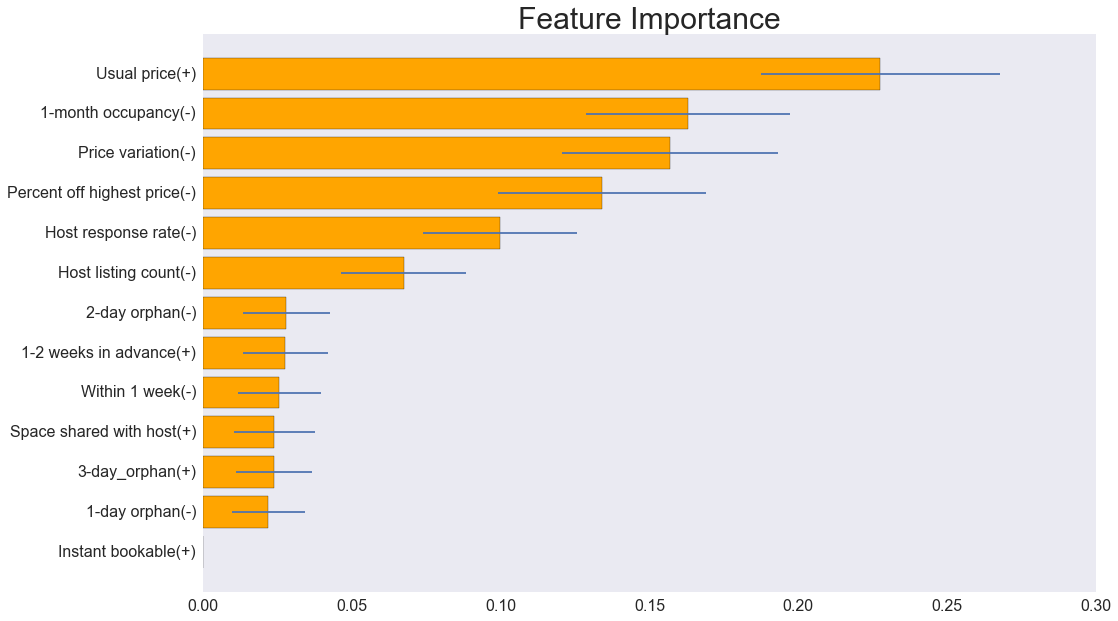

In [29]:
scores_classifier = ["precision", "recall", "f1", "roc_auc"]
clf_all_rf = RandomForestClassifier(n_estimators=1000, 
                                max_features=int(np.sqrt(X_all_rf.shape[1])), 
                                max_depth=None,
                                min_samples_split=1)
clf_all_lr = LogisticRegression()
result_all = model_fitting(clf_all_rf, clf_all_lr, X_all_rf, X_all_lr, Y_all, scores_classifier, label_rf=label_rf, label_lr=label_lr, fold=3)

In [33]:
from sklearn.externals import joblib

clf_rf = RandomForestClassifier(n_estimators=1000, 
                        max_features=int(np.sqrt(X_all_rf.shape[1])), 
                        max_depth=None,
                        min_samples_split=1)

clf_rf.fit(X_all_rf,Y_all)

# now you can save it to a file
joblib.dump(clf_rf, 'clf_all_rf.pkl') 
# and later you can load it
clf = joblib.load('clf_all_rf.pkl')

Y_test = clf.predict(X_all_rf[50])
print Y_test

[ 1.]


/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [34]:
import pickle
# now you can save it to a file
with open('filename.pkl', 'wb') as f:
    pickle.dump(clf_rf, f)

# and later you can load it
with open('filename.pkl', 'rb') as f:
    clf = pickle.load(f)

Average mean_squared_error: 
-0.0112732240353
Average r2: 
-0.144061906433


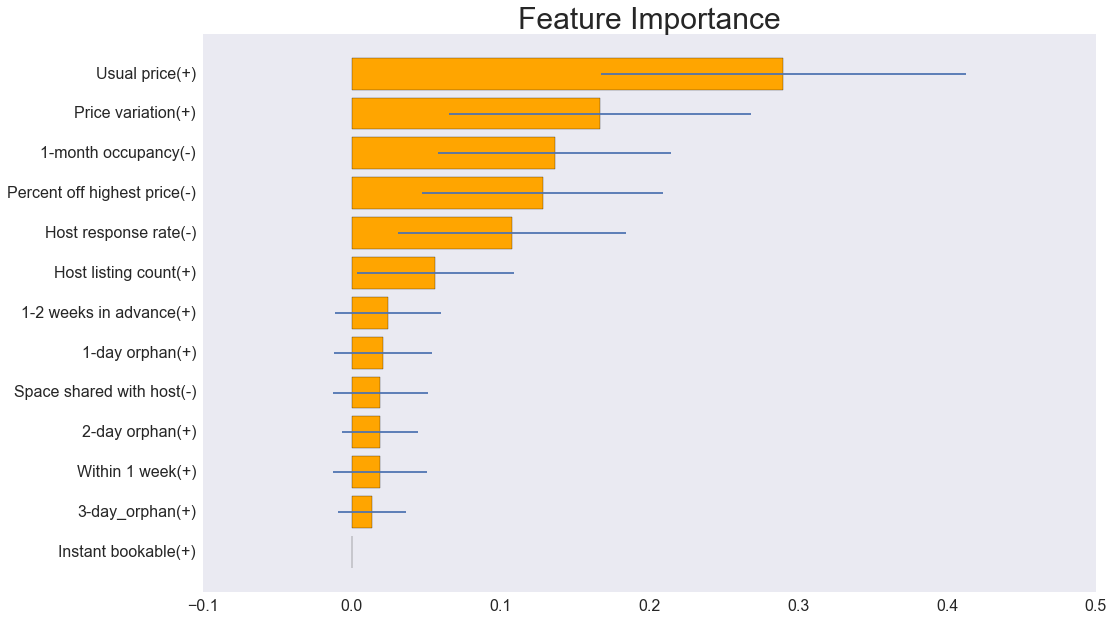

In [119]:
scores_regressor = ["mean_squared_error", "r2"]
clf_rf = RandomForestRegressor(n_estimators=1000, 
                                max_features=int(X_discount_rf.shape[1]), 
                                max_depth=None,
                                min_samples_split=1)
clf_lr = LinearRegression()

result_discount = model_fitting(clf_rf, clf_lr, X_discount_rf, X_discount_lr, Y_discount, scores_regressor, label_rf=label_rf, label_lr=label_lr, fold=3)

In [25]:
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(max_depth=None, n_estimators=1000, max_features=5),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

print "Average Cross Validation F-Score:"
for name, clf in zip(names, classifiers):
    clf.fit(X_all_rf, Y_all)
    cv_scores = cross_val_score(clf, X_all_rf, Y_all, scoring='f1', cv=5)

    print "%s: "%name, np.mean(cv_scores)

Average Cross Validation F-Score:
Nearest Neighbors:  0.244395957155
Linear SVM:  0.0
RBF SVM:  0.0254032258065
Decision Tree:  0.306400558385
Random Forest:  0.0663663663664
AdaBoost:  0.0995816842256
Naive Bayes:  0.270103071933
Linear Discriminant Analysis:  0.0
Quadratic Discriminant Analysis:  0.327434760216
